In [180]:
import geopy, time
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import nltk
import pandas as pd


In [181]:
# let's load in the result of our NER algorithm run in HTRC Analytics

entities = open('/Users/rdubnic2/Desktop/entities.csv','r')
ent_df = pd.read_csv(entities)

ent_df.head()

,vol_id,page_seq,entity,type
0,mdp.39015073487137,1,Walter Paget,PERSON
1,mdp.39015073487137,1,Alfred Henty,PERSON
2,mdp.39015073487137,7,AGINCOURT,LOCATION
3,mdp.39015073487137,11,CHARI,ORGANIZATION
4,mdp.39015073487137,13,Bartholomew,PERSON


In [198]:
place_list = []

for i, r in ent_df.iterrows():
    name = r['entity']
    ner_type = r['type']
    if ner_type == 'LOCATION':
        place_list.append(name)
    else:
        continue
        
print(len(place_list))

37842


In [199]:
# show how geocoding in geopy works
api = geopy.geocoders.Nominatim(user_agent="my-application") # using Nominatim as our geocoding engine instead 
                                                             # of Google geocoder, which requires an API key
    
result, (lat, lng) = api.geocode("1600 Pennsylvania Ave NW, Washington D.C.") # here a 'reverse' geocode, getting 
                                                                              # a place name from an address, 
                                                                              # rather than inferring address or 
                                                                              # coordinates from a place name
print(result)
print(lat, lng)

White House, 1600, Pennsylvania Avenue Northwest, Golden Triangle, Washington, D.C., 20500, USA
38.8976998 -77.0365534886228


In [212]:
place_coord = []

for placename in place_list[:50]:
    time.sleep(1)
    try:
        fullname, (lat, lng) = api.geocode(placename)
        # print(placename + ":  " + fullname)
        # print(lat, lng)
        place_coord.append((lng, lat))
    except:
        print('Could not find: ' + placename)
        
print(len(place_coord))

Could not find: Monstrellet
Could not find: Montepone
48


In [219]:
# Now that we have place names and coordinates, we need only plot them. We'll use Cartopy, a specialized library
# for plotting geographic data using matplotlib. It has many built-in features that we'll demo below.

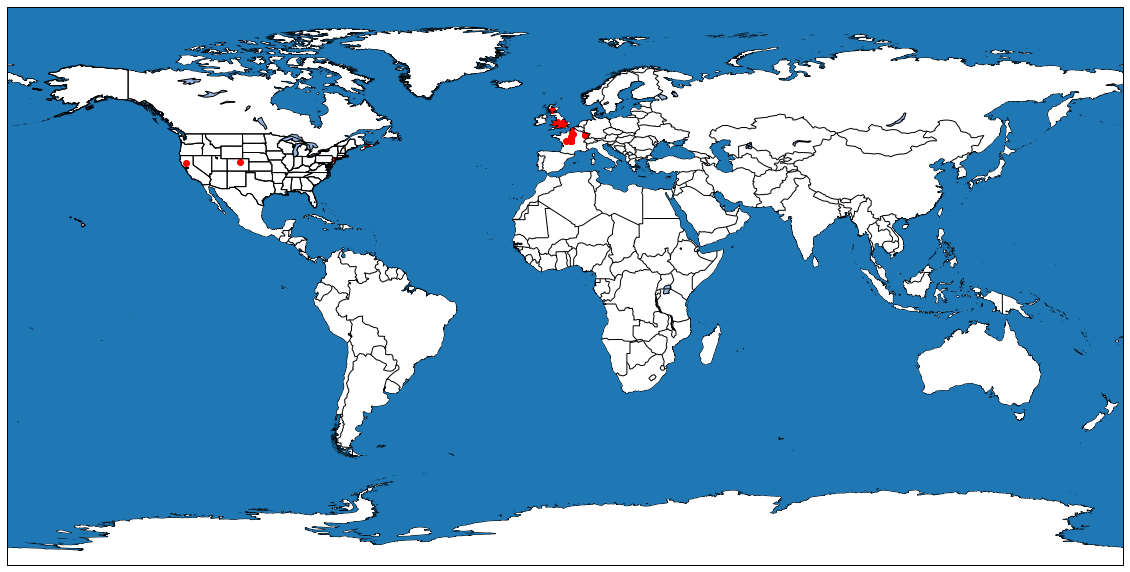

In [218]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
# ax.stock_img()
ax.coastlines(resolution='10m')
ax.set_global()

for lon, lat in place_coord:
    plt.scatter(lon, lat, color='red', transform=ccrs.PlateCarree())

# rivers_10m = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m')
ocean_10m = cfeature.NaturalEarthFeature('physical', 'ocean', '10m')
# phys_labels = cfeature.NaturalEarthFeature('physical','physical-labels', '10m')

ax.add_feature(ocean_10m)
# ax.add_feature(cfeature.OCEAN)
# ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.LAKES, edgecolor='black')
# ax.add_feature(phys_labels)
# ax.add_feature(cfeature.RIVERS)
# ax.add_feature(rivers_10m, facecolor='none', edgecolor='b')
ax.add_feature(cfeature.BORDERS)
# ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
plt.show()

## Below information goes over replicating this process, but using full text rather than EF/tokens.

In [ ]:
# If you want to extract entities a different way, NLTK has built-in tools to do this, if fed raw [full] text.
# We must first run some pre-processing to generate part-of-speech tags, which are necessary to NLTK's NER:

In [68]:
sample_string = 'I live in Champaign, but I often travel to Chicago, Istanbul, and London.'
words = nltk.word_tokenize(sample_string)
tagged = nltk.pos_tag(words)
print(tagged)


[('I', 'PRP'), ('live', 'VBP'), ('in', 'IN'), ('Champaign', 'NNP'), (',', ','), ('but', 'CC'), ('I', 'PRP'), ('often', 'RB'), ('travel', 'VBP'), ('to', 'TO'), ('Chicago', 'NNP'), (',', ','), ('Istanbul', 'NNP'), (',', ','), ('and', 'CC'), ('London', 'NNP'), ('.', '.')]


In [69]:
# Now we're using an NTLK method 'chunking' to extract named entities:

sample_chunked = nltk.ne_chunk(tagged)
# sample_chunked.draw()
print(sample_chunked)
print(type(sample_chunked))


(S
  I/PRP
  live/VBP
  in/IN
  (GPE Champaign/NNP)
  ,/,
  but/CC
  I/PRP
  often/RB
  travel/VBP
  to/TO
  (GPE Chicago/NNP)
  ,/,
  (GPE Istanbul/NNP)
  ,/,
  and/CC
  (GPE London/NNP)
  ./.)
<class 'nltk.tree.Tree'>


In [71]:
# In order to demo extracting place names from a string, we need to define a function that will return items from
# an NLTK Tree with the type 'GPE' (geo-political entity) or 'ORGANIZATION' (or other tags, as appropriate).
# This function takes an NLTK Tree object as input.

# function for navigating an object of type nltk.Tree, in order to extract places

# The code here is adapted from a Stack Overflow answer by alvas
# http://stackoverflow.com/questions/31836058/nltk-named-entity-recognition-to-a-python-list

def get_placenames(parsed_tree):
    prev = None
    continuous_chunk = []
    current_chunk = []
    for node in parsed_tree:
        if type(node) == nltk.Tree and (node.label() == "GPE" or node.label() == 'ORGANIZATION'):
            current_chunk.append(" ".join([token for token, pos in node.leaves()]))
        elif current_chunk:
            named_entity = " ".join(current_chunk)
            if named_entity not in continuous_chunk:
                continuous_chunk.append(named_entity)
                current_chunk = []
        else:
            continue
    return continuous_chunk

print(get_placenames(sample_chunked))

['Champaign', 'Chicago', 'Istanbul', 'London']


In [72]:
# example of extracting place names from a string, using chunking, 
# which will retain some n-grams that NLTK flags as potential entities

text = ' '.join(["I stuffed a shirt or two into my old carpet-bag, tucked it ",
        "under my arm, and started for Cape Horn and the Pacific. Quitting ",
        "the good city of old Manhatto, I duly arrived in New Bedford. ",
        "It was a Saturday night in December. Much was I disappointed ",
        "upon learning that the little packet for Nantucket had already sailed, ",
        "and that no way of reaching that place would offer, till the following ",
        "Monday. As most young candidates for the pains and penalties of whaling ",
        "stop at this same New Bedford, thence to embark on their voyage, it may ",
        "as well be related that I, for one, had no idea of so doing. For ",
        "my mind was made up to sail in no other than a Nantucket craft, ",
        "because there was a fine, boisterous something about everything ",
        "connected with that famous old island, which amazingly pleased me. ",
        "Besides though New Bedford has of late been gradually monopolising ",
        "the business of whaling, and though in this matter poor old Nantucket ",
        "is now much behind her, yet Nantucket was her great original - the Tyre ",
        "of this Carthage;—the place where the first dead American whale was ",
        "stranded. Where else but from Nantucket did those aboriginal whalemen, ",
        "the Red-Men, first sally out in canoes to give chase to the Leviathan? ",
        "And where but from Nantucket, too, did that first adventurous little sloop ",
        "put forth, partly laden with imported cobblestones - so goes the story - ",
        "to throw at the whales, in order to discover when they were nigh enough ",
        "to risk a harpoon from the bowsprit?"])

sentences = nltk.sent_tokenize(text)

# Before we proceed to word_tokenize, we break the block of text into 
# a list of sentences. The tagging and chunking processes tend to work
# better on strings that are single sentences.

# Then we loop through the sentences, tagging and chunking each one,
# extracting placenames, and adding those to a growing list of
# moby_places. Note that "extend" is like "append" but appends
# all the elements of a list.

moby_places = []

for s in sentences:
    words = nltk.word_tokenize(s)
    tagged = nltk.pos_tag(words)
    namedEnt = nltk.ne_chunk(tagged)
    chunks = get_placenames(namedEnt)
    moby_places.extend(chunks)

print('\nPLACENAMES: ')
print(moby_places)


PLACENAMES: 
['Pacific', 'New Bedford', 'New Bedford', 'New Bedford', 'Tyre', 'Carthage', 'American', 'Leviathan', 'Nantucket']


In [ ]:
# illustrating geocoding of places extracted from the above excerpt of Moby Dick

allcoordinates = []

for placename in moby_places:
    time.sleep(1)
    try:
        fullname, (lat, lng) = api.geocode(placename)
        print(placename + ":  " + fullname)
        print(lat, lng)
        allcoordinates.append((lng, lat))
    except:
        print('Could not find: ' + placename)

In [84]:
# We can also try this for our sample sentence:

sample_sentences = ['I live in Champaign, but I often travel to Chicago, Istanbul, and London. This travel schedule is typical for a world-famous pop start such as myself.']
sample_places = []

for s in sample_sentences:
    words = nltk.word_tokenize(s)
    tagged = nltk.pos_tag(words)
    # print(tagged)
    namedEnt = nltk.ne_chunk(tagged)
    # print(namedEnt)
    chunks = get_placenames(namedEnt)
    sample_places.extend(chunks)
    
print(sample_places)

sample_coord = []

for placename in sample_places:
    time.sleep(1)
    try:
        fullname, (lat, lng) = api.geocode(placename)
        print(placename + ":  " + fullname)
        print(lat, lng)
        sample_coord.append((lng, lat))
    except:
        print('Could not find: ' + placename)
        
print(sample_coord)

['Champaign', 'Chicago', 'Istanbul', 'London']
Champaign:  Champaign, Champaign County, Illinois, USA
40.1164205 -88.2433829
Chicago:  Chicago, Cook County, Illinois, United States of America
41.8755616 -87.6244212
Istanbul:  İstanbul, Fatih, İstanbul, Marmara Bölgesi, 34126, Türkiye
41.0096334 28.9651646
London:  London, Greater London, England, SW1A 2DX, United Kingdom
51.5073219 -0.1276474
[(-88.2433829, 40.1164205), (-87.6244212, 41.8755616), (28.9651646, 41.0096334), (-0.1276474, 51.5073219)]


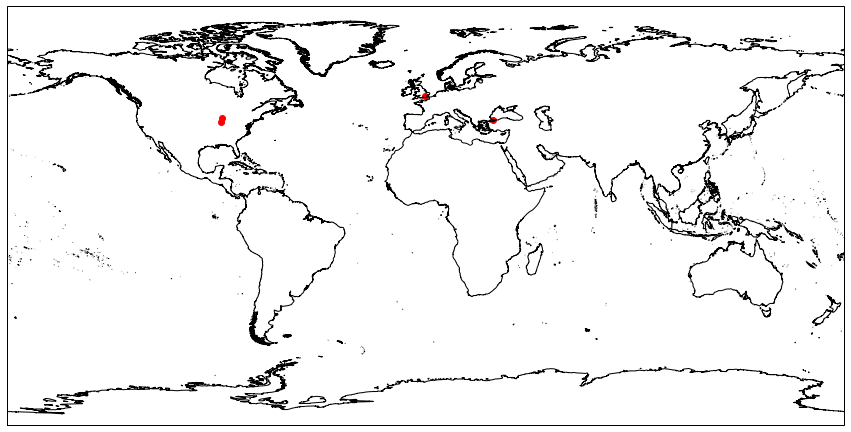

In [94]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
# ax.stock_img()
ax.coastlines(resolution='10m')
ax.set_global()

for lon, lat in sample_coord:
    plt.scatter(lon, lat, color='red', transform=ccrs.PlateCarree())
    
plt.show()

In [95]:
# OR we could do this for our own list of place names, such as Premier League stadia:

pl_stadia = ['Anfield', 'Goodison Park', 'Old Trafford', 'City of Manchester Stadium', 'Carrow Road', 
             'Bramall Lane','Emirates Stadium','Stamford Bridge', 'London Stadium', "St. James' Park",
             'Dean Court', 'Falmer Stadium', 'King Power Stadium', 'Molineux Stadium', "Southampton FC",
             'Selhurst Park', 'Tottenham Hotspur Stadium', 'Turf Moor', 'Vicarage Road', 'Villa Park']

pl_coord = []

for placename in pl_stadia:
    time.sleep(1)
    try:
        fullname, (lat, lng) = api.geocode(placename)
        print(placename + ":  " + fullname)
        print(lat, lng)
        pl_coord.append((lng, lat))
    except:
        print('Could not find: ' + placename)

Anfield:  Anfield, Anfield Road, Walton, Liverpool, North West England, England, L4 0TH, UK
53.4308358 -2.96090954141653
Goodison Park:  Goodison Park, Goodison Road, Walton, Liverpool, North West England, England, L4 4EL, UK
53.4387191 -2.96645399390874
Old Trafford:  Old Trafford, Munich Tunnel, Wharfside, Trafford, Greater Manchester, North West England, England, M16 0RA, UK
53.46310955 -2.29138648505454
City of Manchester Stadium:  Etihad Stadium, Joe Mercer Way, Beswick, Manchester, Greater Manchester, North West England, England, M11 3FF, UK
53.48309105 -2.20025200234333
Carrow Road:  Carrow Road, Lakenham, Norwich, Norfolk, East of England, England, NR1 2BT, UK
52.6214386 1.3067458
Bramall Lane:  Bramall Lane, Moorfoot, Highfield, Sheffield, Yorkshire and the Humber, England, S2 4FQ, UK
53.3720415 -1.4726317
Emirates Stadium:  Emirates Stadium, 75, Drayton Park, Finsbury Park, London Borough of Islington, London, Greater London, England, N5 1BU, UK
51.55504035 -0.108399670867237

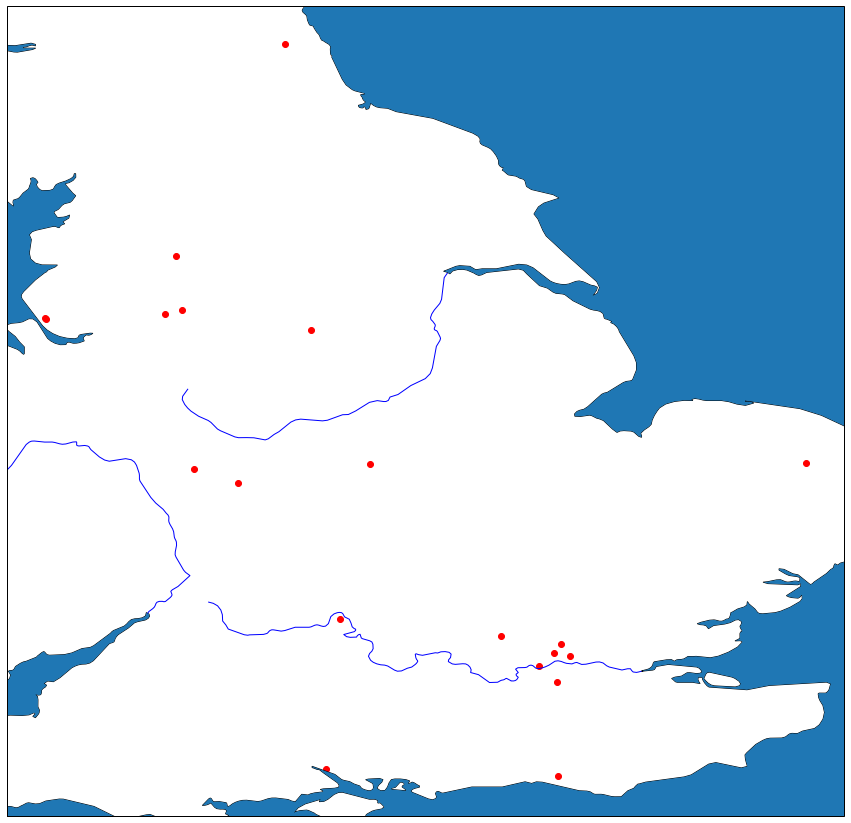

In [157]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
# ax.stock_img()
ax.coastlines(resolution='10m')
# ax.set_global()

for lon, lat in pl_coord:
    plt.scatter(lon, lat, color='red', alpha=1, transform=ccrs.PlateCarree())

    
rivers_10m = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m')
ocean_10m = cfeature.NaturalEarthFeature('physical', 'ocean', '10m')
# phys_labels = cfeature.NaturalEarthFeature('physical','physical-labels', '10m')

ax.add_feature(ocean_10m)
# ax.add_feature(cfeature.OCEAN)
# ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.LAKES, edgecolor='black')
# ax.add_feature(phys_labels)
# ax.add_feature(cfeature.RIVERS)
ax.add_feature(rivers_10m, facecolor='none', edgecolor='b')
ax.add_feature(cfeature.BORDERS)
# ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
# ax.gridlines()

plt.show()

In [148]:
cfeature.NaturalEarthFeature?